Contributors: Bhairav Valera, Michael Wood-Vasey (owner of tutorial code)

In [1]:
import os
import numpy as np
import random
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

from astropy.table import Table
from astropy.visualization import ZScaleInterval

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)
zscale = ZScaleInterval()

In [3]:
def cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd', **kwargs):
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    return cutout_coadd_spherepoint(butler, radec, filter=filter, datasetType=datasetType)

def cutout_coadd_spherepoint(butler, radec, filter='r', datasetType='deepCoadd',
                             skymap=None, cutoutSideLength=200, **kwargs):
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)
    if skymap is None:
        skymap = butler.get("%s_skyMap" % datasetType)
     # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)
    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filter}
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    return cutout_image

In [4]:
def make_cutout_image(butler, ra, dec, filter='r', vmin=None, vmax=None, label=None,
                      show=True, saveplot=False, savefits=False,
                      datasetType='deepCoadd'):
    cutout_image = cutout_coadd_ra_dec(butler, ra, dec, filter=filter, datasetType='deepCoadd')
    if savefits:
        if isinstance(savefits, str):
            filename = savefits
        else:
            filename = 'postage-stamp.fits'
        cutout_image.writeFits(filename)
    
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    
    if vmin is None or vmax is None:
        vmin, vmax = zscale.get_limits(cutout_image.image.array)

    plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    plt.colorbar()
    plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(),
                color='none', edgecolor='red', marker='o', s=200)
    if label is not None:
        plt.title(label)
    if saveplot:
        if isinstance(saveplot, str):
            filename = saveplot
        else:
            filename = 'postage-stamp.png'
        plt.savefig(filename)
    if show:
        plt.show()

    return cutout_image

In [5]:
%store -r bright_objects_filtered_idx01
%store -r bright_objects_filtered_ra01
%store -r bright_objects_filtered_dec01

%store -r mid_objects_filtered_idx01
%store -r mid_objects_filtered_ra01
%store -r mid_objects_filtered_dec01

%store -r dim_objects_filtered_idx01
%store -r dim_objects_filtered_ra01
%store -r dim_objects_filtered_dec01

%store -r bright_objects_filtered_idx11
%store -r bright_objects_filtered_ra11
%store -r bright_objects_filtered_dec11

In [6]:
bright_objects_filtered_idx01 = np.array(bright_objects_filtered_idx01).tolist()
bright_objects_filtered_ra01 = np.array(bright_objects_filtered_ra01).tolist()
bright_objects_filtered_dec01 = np.array(bright_objects_filtered_dec01).tolist()

mid_objects_filtered_idx01 = np.array(mid_objects_filtered_idx01).tolist()
mid_objects_filtered_ra01 = np.array(mid_objects_filtered_ra01).tolist()
mid_objects_filtered_dec01 = np.array(mid_objects_filtered_dec01).tolist()

dim_objects_filtered_idx01 = np.array(dim_objects_filtered_idx01).tolist()
dim_objects_filtered_ra01 = np.array(dim_objects_filtered_ra01).tolist()
dim_objects_filtered_dec01 = np.array(dim_objects_filtered_dec01).tolist()

bright_objects_filtered_idx11 = np.array(bright_objects_filtered_idx11).tolist()
bright_objects_filtered_ra11 = np.array(bright_objects_filtered_ra11).tolist()
bright_objects_filtered_dec11 = np.array(bright_objects_filtered_dec11).tolist()

In [7]:
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dafPersist.Butler(repo)

In [8]:
bright_objects_table01 = Table([bright_objects_filtered_idx01,
                              bright_objects_filtered_ra01,
                              bright_objects_filtered_dec01], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})

mid_objects_table01 = Table([mid_objects_filtered_idx01,
                              mid_objects_filtered_ra01,
                              mid_objects_filtered_dec01], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})

dim_objects_table01 = Table([dim_objects_filtered_idx01,
                              dim_objects_filtered_ra01,
                              dim_objects_filtered_dec01], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})

bright_objects_table11 = Table([bright_objects_filtered_idx11,
                              bright_objects_filtered_ra11,
                              bright_objects_filtered_dec11], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table11'})

print(bright_objects_table01)
print(mid_objects_table01)
print(dim_objects_table01)

   ID         RA           DEC      
------- ------------- --------------
2145918 57.9184954941 -30.1313293125
   ID         RA           DEC      
------- ------------- --------------
 149988 55.9578674774 -31.5325987173
 190700 55.6157800784   -31.69176712
 594726 53.0917926321 -30.3930630162
 648319 52.6673343944 -30.3248249313
 659547 52.8750305108 -30.1734761197
 659552 52.8724495875 -30.1751906978
 675510 52.8645312165 -29.7805689643
 894891 55.0105221391 -30.9899695097
1041878 54.8208593852 -30.3133503226
1070753 54.7014617736 -29.9419425726
    ...           ...            ...
6724860 57.8915258046 -27.0929562649
6724881 57.8931502039 -27.0876655009
6724900 57.8813294362 -27.0807649824
6724913  57.930575574 -27.0679224163
6724914 57.9296537538 -27.0666882859
6724978 57.9332856476 -27.0697748396
6761136 57.7226415327 -27.5255569523
6768284 57.7584793438 -27.3293846544
6768292 57.7610529854 -27.3327645808
6870681 57.2592343936 -27.5716300432
6874192  57.243518662 -27.6450709034
L

In [9]:
subfolder = 'Stamps'
if not os.path.exists(subfolder):
    os.mkdir(subfolder)

In [10]:
"""random_bright_table11 = Table([[0], [float(0)], [float(0)]], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})
count = 0
while count < 5:
    row = random.choice(bright_objects_table11)
    random_bright_table11.add_row(row)
    count+=1
random_bright_table11.remove_row(0)
print(random_bright_table11)"""

"random_bright_table11 = Table([[0], [float(0)], [float(0)]], names=('ID', 'RA', 'DEC'), \n                              meta={'name' : 'bright_objects_table01'})\ncount = 0\nwhile count < 5:\n    row = random.choice(bright_objects_table11)\n    random_bright_table11.add_row(row)\n    count+=1\nrandom_bright_table11.remove_row(0)\nprint(random_bright_table11)"

In [11]:
mid_objects_table01_cut = Table([[0], [float(0)], [float(0)]], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})
dim_objects_table01_cut = Table([[0], [float(0)], [float(0)]], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})

midCount = 0
dimCount = 0
while midCount < 10:
    row = random.choice(mid_objects_table01)
    mid_objects_table01_cut.add_row(row)
    midCount+=1
while dimCount < 10:
    row = random.choice(dim_objects_table01)
    dim_objects_table01_cut.add_row(row)
    dimCount+=1
mid_objects_table01_cut.remove_row(0)
dim_objects_table01_cut.remove_row(0)
print(mid_objects_table01_cut)
print(dim_objects_table01_cut)

   ID         RA           DEC      
------- ------------- --------------
6768292 57.7610529854 -27.3327645808
2546213 52.7149841859 -28.4414254386
6724835 57.9101613097 -27.0989386206
2864946 54.5269845369 -28.7368882724
4556693 57.2514519882 -28.7509003695
5900497 54.6933338851  -27.074039356
2700421  52.201902132 -28.2733641946
2612924 52.4256713762 -28.5068470929
2612679 52.4240488344 -28.5396405432
2905144 54.1808092754 -29.6760610818
   ID         RA           DEC      
------- ------------- --------------
4414667 57.4664649218 -29.1298878002
4341388 57.7610293284 -28.5951170877
3701719 55.8473812364 -29.3479563344
6492070 55.9460773034 -28.1728011624
2893852 54.5204704541  -28.344983705
1342300  53.926808446 -29.9756533365
4897976  56.661441033 -28.5958809889
1855288 55.8726363736 -31.0286568009
5806863 54.7753725796 -27.4867054568
6164582 56.9829224547 -28.1892220784


In [12]:
"""frame = 5
vmin, vmax = -1.5, +5.5
filter = 'i'
show = True
saveplot = False
datasetType = 'deepCoadd'

for objectId, ra, dec in save_table:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)"""

'frame = 5\nvmin, vmax = -1.5, +5.5\nfilter = \'i\'\nshow = True\nsaveplot = False\ndatasetType = \'deepCoadd\'\n\nfor objectId, ra, dec in save_table:\n    plt.figure(frame)\n    plt.clf()\n    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)\n    saveplot = "%s.png" % basename\n    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,\n                      label="Object ID: %d" % objectId,\n                      show=show, saveplot=saveplot)'

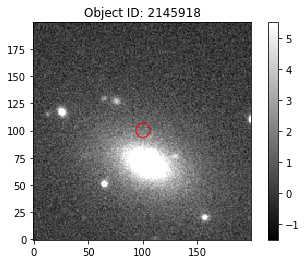

In [13]:
frame = 1
vmin, vmax = -1.5, +5.5
filter = 'i'
show = True
saveplot = False
datasetType = 'deepCoadd'

for objectId, ra, dec in bright_objects_table01:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)

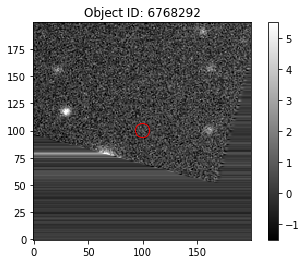

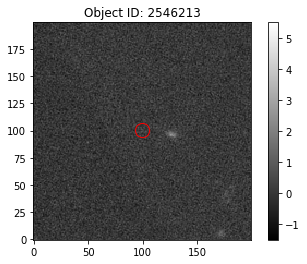

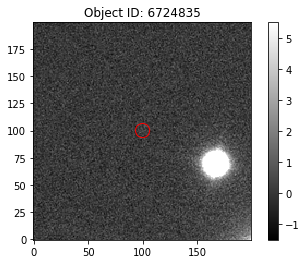

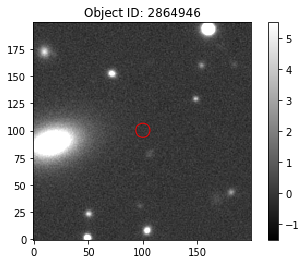

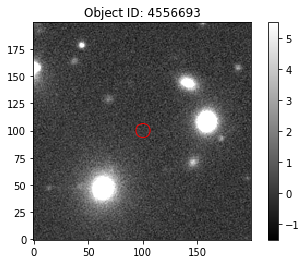

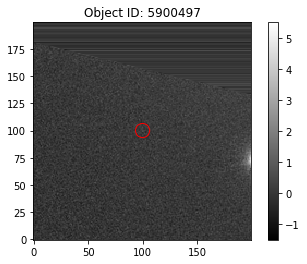

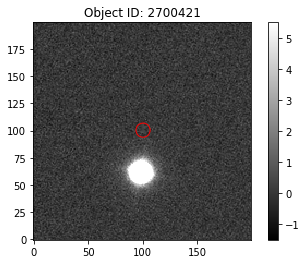

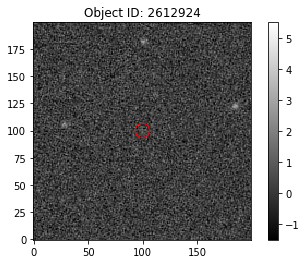

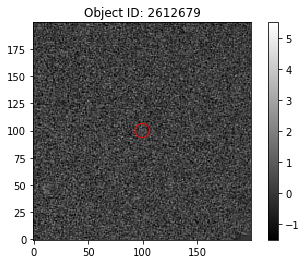

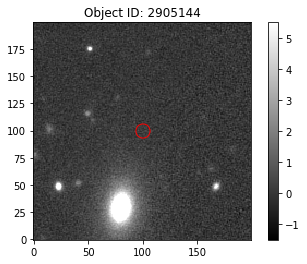

In [14]:
frame = 1
vmin, vmax = -1.5, +5.5
filter = 'i'
show = True
saveplot = False
datasetType = 'deepCoadd'

for objectId, ra, dec in mid_objects_table01_cut:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)

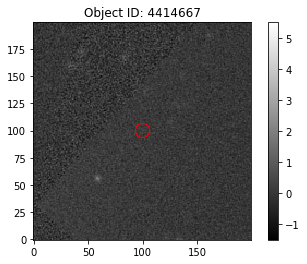

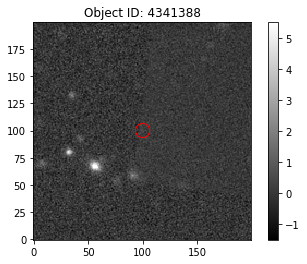

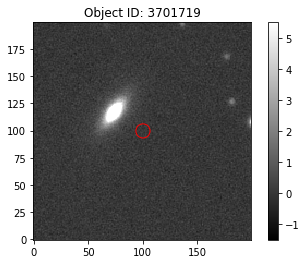

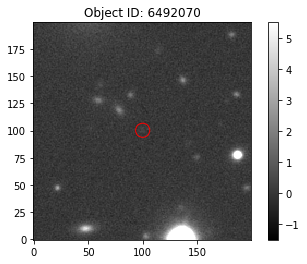

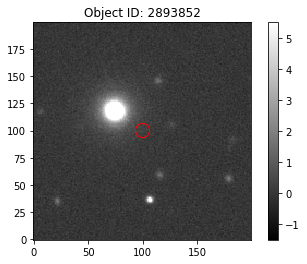

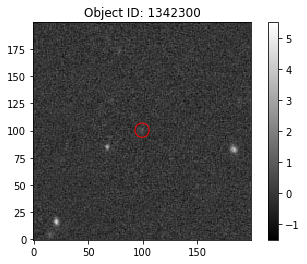

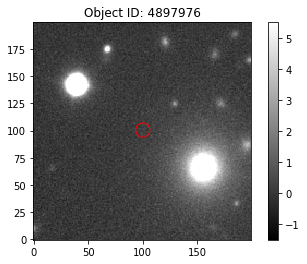

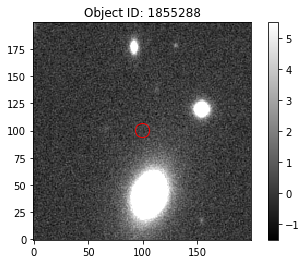

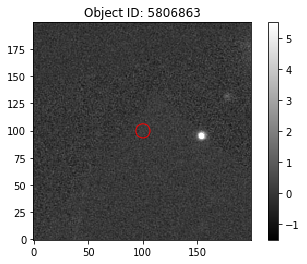

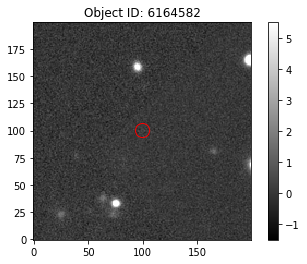

In [15]:
frame = 1
vmin, vmax = -1.5, +5.5
filter = 'i'
show = True
saveplot = False
datasetType = 'deepCoadd'

for objectId, ra, dec in dim_objects_table01_cut:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)